In [7]:
# 这是最简单的 LTSM 模型
import torch
import torch.nn as nn

# 初始化的 lstm 模型
lstm_model = nn.LSTM(10, 20, 2)                    # 参数为(input_size, hidden_size, num_layers)

# 模型的cell接受的输入参数
x = torch.randn(5, 3, 10)                         # 参数为(seq_len, batch, input_size)
# 模型的cell接受的输入hidden_state；也是前一个cell的输出hidden_state
h0 = torch.randn(2, 3, 20)                         # 参数为(num_layers * num_directions, batch, hidden_size)
# 模型的cell初始值
c0 = torch.randn(2, 3, 20)                         # 参数为(num_layers * num_directions, batch, hidden_size)

y, (h1, c1) = lstm_model(x, (h0, c0))

print(y.size())
print(h1.size())
print(c1.size())


torch.Size([5, 3, 20])
torch.Size([2, 3, 20])
torch.Size([2, 3, 20])


In [1]:
# GPU -- 准备来做一个GPU版本的LSTM做股票预测
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("000600.csv", index_col=0)
dataset = dataset.drop(['date','prediction'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset['updown'] = dataset['updown']
print(dataset.shape)
# print(dataset.tail())

# 方法2，将数据按照batch_size的窗口进行滑动，每个窗口数据做一组

# # 数据转成sequence的格式，这里定义每个seq的长度
seq_len = 21
batch_size = 2                                                    # 注意：batch_size是要能够整除seq_count的

# 把数据切换成 batch_size 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(seq_len):
    if i.shape[0] == seq_len:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, seq_len, 118)                 # 数据一共是 seq_count x seq_len x in_dim

print("rolling_data: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                 # 所以一共有 seq_count 列数据，每一行的数据是118维 （包括y）
print("seq length: {}".format(seq_len))


total_batch_count = int(rolling_data.shape[0]/batch_size)                          # 把数据规划成 batch_count 个 batch

print("total batch count: {}".format(total_batch_count))
print("batch size: {}".format(batch_size))

rolling_data = rolling_data.reshape(total_batch_count, batch_size, seq_len, 118)  # 把数据转成 total_batch_count x batch_size x seq_len x in_dim 格式
rolling_data = torch.tensor(rolling_data)
print("rolling_data: {}".format(rolling_data.shape))


train_batch_count = total_batch_count - 1
test_batch_count = total_batch_count - train_batch_count

train = rolling_data[:train_batch_count, :, :, :]
test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,1:], train[:,:,:,0:1]
test_x,  test_y  = test[:,:,:, 1:],  test[:,:,:,0:1]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train_batch_count))
print("test_batch_count:  {}".format(test_batch_count))

(150, 118)
rolling_data: (130, 21, 118)
seq count: 130
seq length: 21
total batch count: 65
batch size: 2
rolling_data: torch.Size([65, 2, 21, 118])
train_x: torch.Size([64, 2, 21, 117])
train_y: torch.Size([64, 2, 21, 1])
test_x:  torch.Size([1, 2, 21, 117])
test_y:  torch.Size([1, 2, 21, 1])
train_batch_count: 64
test_batch_count:  1


In [2]:
# 开始定义 LSTM 模型
TIME_STEP = seq_len                                        # 一般这个单独设定，这里为了简单，还是直接就等于seq_len的方便。其实也就是等于最长的那个sequence length
INPUT_SIZE = 117
HIDDEN_SIZE = 768
NUM_LAYERS = 3

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=hidden_layer_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)
        
        # self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        h0 = torch.zeros(NUM_LAYERS, batch_size, HIDDEN_SIZE).requires_grad_().double().to(device)
        c0 = torch.zeros(NUM_LAYERS, batch_size, HIDDEN_SIZE).requires_grad_().double().to(device)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x, (h0.detach(), c0.detach()))

        # lstm_out = self.dropout(lstm_out)
        predictions = self.linear_2(lstm_out)
        return predictions


In [3]:
# 初始化 LSTM 模型
model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)
model = model.to(device)
LR = 5e-5
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)

print(model)

# 训练 LSTM 模型; 
i = 0
epoches = 100
print(time.ctime())
for epoch in range(epoches):
    for step in range(train_batch_count):
        # print(train_x[i])
        # print(train_x[i].shape)
        model = model.double()

        pred = model(train_x[i])
        
        # pred.to('cpu')
        # print("pred   : {}".format(pred.shape))
        # print("train_y: {}".format(train_y[i].shape))
        loss = loss_func(pred, train_y[i])
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()

        if (i+1)%train_batch_count == 0:
            i=0
        else:
            i=i+1
    if (epoch+1)%10 == 0:
        print("{} of {} epoch loss: {:.6f}".format(epoch, epoches, loss.item()))

print(time.ctime())

LSTMModel(
  (linear_1): Linear(in_features=117, out_features=768, bias=True)
  (relu): ReLU()
  (lstm): LSTM(768, 768, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=768, out_features=1, bias=True)
)
Thu Feb 24 14:30:00 2022
9 of 100 epoch loss: 0.000255
19 of 100 epoch loss: 0.000151
29 of 100 epoch loss: 0.000096
39 of 100 epoch loss: 0.000060
49 of 100 epoch loss: 0.000055
59 of 100 epoch loss: 0.000029
69 of 100 epoch loss: 0.000020
79 of 100 epoch loss: 0.000016
89 of 100 epoch loss: 0.000011
99 of 100 epoch loss: 0.000011
Thu Feb 24 16:51:26 2022


loss: 0.000029
True


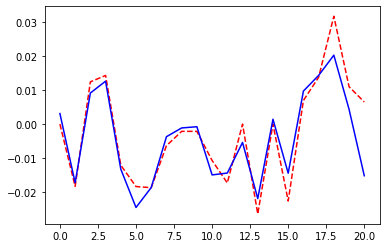

In [4]:
# GPU -- 用模型来做测试数据的误差

pred = model(test_x[0])

test_y=test_y.cpu()
pred = pred.cpu()

loss = loss_func(pred, test_y[0])
print("loss: {:.6f}".format(loss.item()))

# actual_line = np.array(test_y[0]).flatten().tolist()
# pred_line = pred.data.numpy().flatten().tolist()

actual_line = np.array(test_y[0][-1]).flatten().tolist()
pred_line = pred[-1].data.numpy().flatten().tolist()


print(len(actual_line) == len(pred_line))
plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()